### Simulating Future Interest Rates Using Monte Carlo:

Monte Carlo engine is the core of risk simulation framework.

**Why Simulate Interest Rates?**

Because future interest rates are:
- Uncertain
- Often affect the value of financial instruments (like swaps, bonds, or credit exposure),
we use simulation to generate many possible rate paths — each path representing one possible future.

It allows to:
- Calculate exposure over time
- Measure credit risk (counterparty may default while we have positive MtM)
- Value interest rate derivatives that depend on path behavior


**The Geometric Brownian Motion (GBM) Model**:

$r_t = r_{t-1} \cdot \exp\left( (\mu - 0.5 \sigma^2) \Delta t + \sigma \sqrt{\Delta t} Z \right)$

where:
- $r_t$: interest rate at time t
- $\mu$: drift (average growth rate of rates)
- $\sigma$: volatility (how much rates vary)
- $Z \sim \mathcal{N}(0,1)$: random noise
- $\Delta t$: time step size


In [ ]:
#import necessary libraries
import numpy as np #for numerical operations and random number generation.
import pandas as pd #to structure simulated paths into a DataFrame
import matplotlib.pyplot as plt

In [4]:
# Simulation Parameters - define how the short rate evolves over time
S0 = 0.02      # Initial short rate (starting interest rate, 2%)
mu = 0.01      # Drift (long-term average rate)
sigma = 0.01   # Volatility
T = 1.0        # Time horizon (in years)
N = 252        # Number of time steps (daily)
M = 10000      # Number of Monte Carlo paths
dt = T / N     #Size of each time step (in years)


np.random.seed(42) #for reproducibility

# Initialize array for simulated paths
short_rate_paths = np.zeros((M, N + 1)) #Create a 2D array M x (N+1) to store paths
short_rate_paths[:, 0] = S0 #Set first column (time 0) of all simulations to the starting rate S0

# Simulate paths using Geometric Brownian Motion (GBM)
for t in range(1, N + 1):
    Z = np.random.normal(0, 1, M)
    short_rate_paths[:, t] = short_rate_paths[:, t - 1] * np.exp(
        (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    )

**Mathematical explanation**: The loop uses the Geometric Brownian Motion formula:

$S_{t} = S_{t-1} \cdot \exp\left[ \left( \mu - \frac{1}{2} \sigma^2 \right) \Delta t + \sigma \sqrt{\Delta t} Z_t \right]$

where:

- `Z` is a standard normal random number used to simulate Brownian motion

- each simulation evolves over time by compounding the previous rate with drift and volatility.



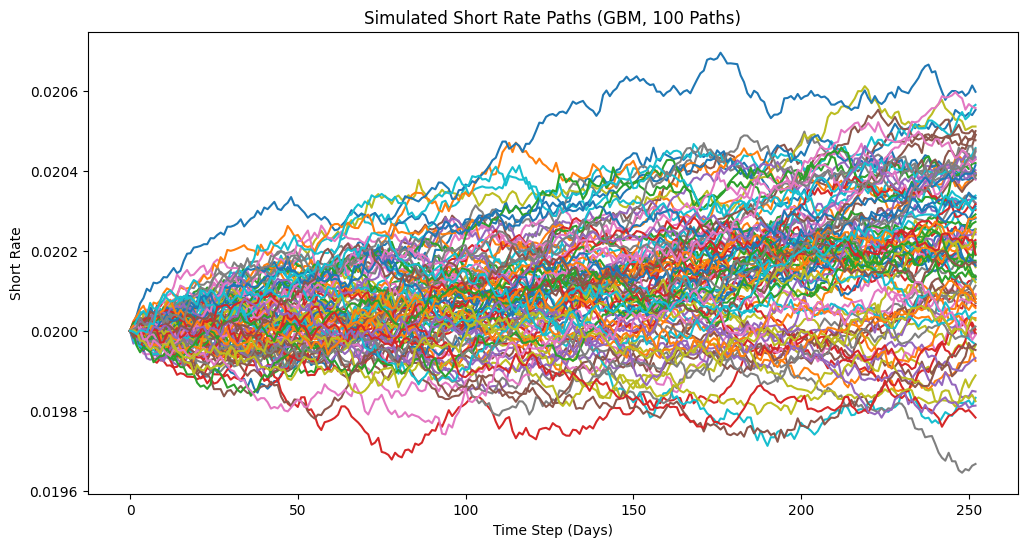

In [6]:
# Plot a few simulated paths
plt.figure(figsize=(12, 6))
plt.plot(short_rate_paths[:100].T)
plt.title("Simulated Short Rate Paths (GBM, 100 Paths)")
plt.xlabel("Time Step (Days)")
plt.ylabel("Short Rate")
plt.show()


In [5]:
# Save simulated paths as DataFrame
dates = pd.date_range(start='2025-01-01', periods=N+1, freq='B')
df_paths = pd.DataFrame(short_rate_paths[:100].T, index=dates)
df_paths.head()


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2025-01-01,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,...,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000
2025-01-02,0.020007,0.019999,0.020009,0.020020,0.019998,0.019998,0.020021,0.020010,0.019995,0.020008,...,0.020002,0.020013,0.019992,0.019997,0.019996,0.019982,0.020005,0.020004,0.020001,0.019998
2025-01-03,0.019999,0.019996,0.020002,0.020022,0.020014,0.019989,0.020034,0.020001,0.019985,0.020019,...,0.019997,0.019999,0.019962,0.019985,0.019995,0.020003,0.020014,0.020009,0.019997,0.019991
2025-01-06,0.020004,0.020000,0.019991,0.020030,0.019996,0.019981,0.020010,0.020022,0.019983,0.020047,...,0.019999,0.019990,0.019946,0.019997,0.020004,0.020017,0.020002,0.020033,0.019975,0.020001
2025-01-07,0.019980,0.019988,0.019985,0.020033,0.020009,0.019991,0.019996,0.020018,0.019985,0.020044,...,0.020007,0.020007,0.019960,0.019991,0.020005,0.020018,0.019976,0.020018,0.019974,0.020000



### Summary:

This code simulates:

-10,000 paths of future interest rates

-252 steps per path (daily steps over 1 year) - each path evolves randomly with drift and volatility.

This simulates real-world uncertainty in how interest rates move.

### In Practical Applications:

current short-term interest rate variable S0 is based on the most recent observed market data:

Example of data sources for S0: Market data feeds (eg Bloomberg), Central bank publications (eg Fed SOFR data) or Bootstrapped yield curves.

When doing daily refresh, this can be automate it  using:

- Bloomberg API
- FRED (Federal Reserve Economic Data)
- or internal data


| Currency | Data source for `S0` | Example|
|----------|----------------|---------|
| USD | SOFR, Fed Funds, 3M LIBOR (legacy) | `S0 = 0.0532` (5.32%) |
| EUR | €STR | `S0 = 0.0385` (3.85%) |
| GBP | SONIA | `S0 = 0.0521` (5.21%) |


### Limitation of GBM model for interest rate simulation:

GBM is simple, but not ideal for interest rates, since interest rates can be mean-reverting -->

A commonly simulation method used short-rate models in risk modeling is **Hull-White Model**:

$dr_t = a(b - r_t)dt + \sigma dW_t $

where

- `a: speed of mean reversion
- `b: long-term average rate
- `σ : volatility
- `r0: initial rate, based on market (e.g., SOFR)


The code below illustrates Hull-White Short Rate Simulation using Monte Carlo:

In [7]:
# Hull-White Model Parameters
a = 0.1            # Speed of mean reversion
b = 0.03           # Long-term mean interest rate (3%)
sigma = 0.01       # Volatility
r0 = 0.0532        # Starting short rate, e.g. current SOFR (~5.32%)

T = 1.0            # Time horizon in years
N = 252            # Number of time steps (daily)
dt = T / N         # Time step size
M = 10000          # Number of Monte Carlo paths


# Initialize rate paths
rate_paths = np.zeros((M, N + 1))
rate_paths[:, 0] = r0

# Simulate using Euler scheme
for t in range(1, N + 1):
    Z = np.random.normal(0, 1, M)
    rate_paths[:, t] = rate_paths[:, t - 1] + a * (b - rate_paths[:, t - 1]) * dt + sigma * np.sqrt(dt) * Z


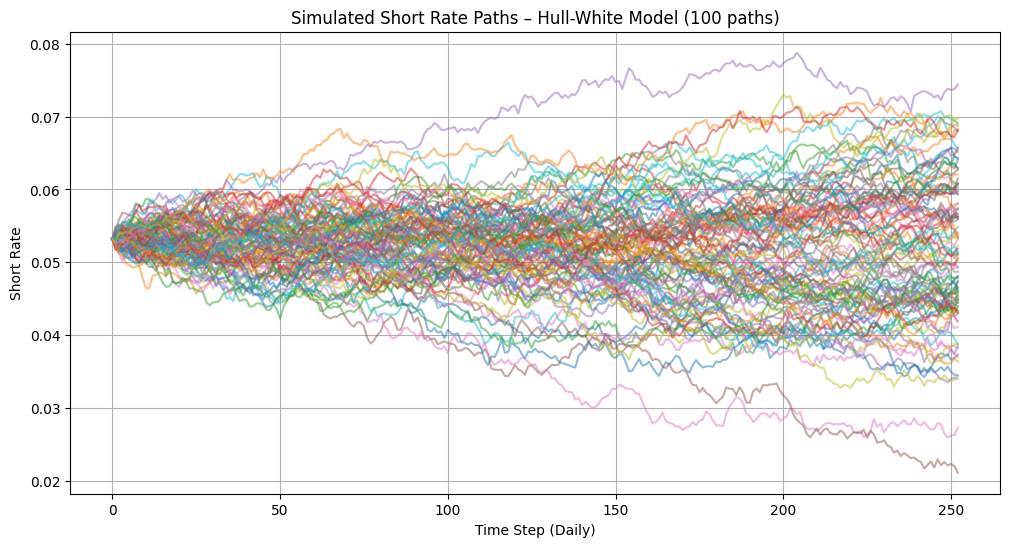

In [8]:
#Plot Sample Paths
plt.figure(figsize=(12, 6))
plt.plot(rate_paths[:100].T, alpha=0.5)
plt.title("Simulated Short Rate Paths – Hull-White Model (100 paths)")
plt.xlabel("Time Step (Daily)")
plt.ylabel("Short Rate")
plt.grid(True)
plt.show()


In [9]:
#convert to DataFrame for analysis
dates = pd.date_range(start="2025-01-01", periods=N+1, freq="B")
df_paths = pd.DataFrame(rate_paths[:100].T, index=dates)
df_paths.head()


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2025-01-01,0.053200,0.053200,0.053200,0.053200,0.053200,0.053200,0.053200,0.053200,0.053200,0.053200,...,0.053200,0.053200,0.053200,0.053200,0.053200,0.053200,0.053200,0.053200,0.053200,0.053200
2025-01-02,0.053583,0.053287,0.052785,0.052868,0.053589,0.054512,0.053940,0.053181,0.053796,0.053553,...,0.053436,0.052005,0.054329,0.054033,0.054404,0.053722,0.052560,0.053756,0.052721,0.053456
2025-01-03,0.052875,0.052887,0.053929,0.053753,0.052759,0.055859,0.053947,0.053608,0.053631,0.054620,...,0.052619,0.052128,0.055035,0.054165,0.054809,0.054486,0.052805,0.054312,0.054056,0.054403
2025-01-06,0.052840,0.053080,0.054457,0.053201,0.052820,0.056790,0.054191,0.053329,0.054155,0.054602,...,0.051519,0.052749,0.054569,0.055072,0.054678,0.054478,0.053080,0.053966,0.053923,0.055615
2025-01-07,0.053484,0.052609,0.053928,0.052731,0.052527,0.056716,0.053009,0.054604,0.054177,0.054514,...,0.052096,0.053130,0.054681,0.054575,0.053456,0.053734,0.052302,0.054180,0.054154,0.055467


**Summary**:

-Monte Carlo simulation is widely used to estimate risk and return in financial applications, especially where no closed-form solutions exist. Is essential when pricing or modeling path-dependent or non-linear risk. It involves random simulations based on probability distributions, and is often the only method available for pricing/valuing when formulas don't exist.

vs

-Bootstrapping: a technique that involves random sampling (with replacement) from a population
to construct the sampling distribution. Since a random sample is a representation of the population, bootstrapping can be used for inference, allowing to estimate statistics like the mean or confidence intervals without needing a full population. It is not used for forward looking.


-Mean-reverting interest rate model:

- Useful for modeling short rates like SOFR, EURIBOR, etc.
- Captures realistic dynamics of interest rates
over time


These paths can then be used to:
- Price interest rate derivatives (e.g., swaps)
- Compute exposure profiles
- Estimate CVA/DVA under counterparty risk